In [1]:
!pip install pyspark


In [2]:
!apt-get update -qq
!apt-get install -y openjdk-8-jdk-headless -qq
!pip install -q pyspark findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u462-ga~us1-0ubuntu2~22.04.2_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u462-ga~us1-0ubuntu2~22.04.2) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u462-ga~us1-0ubuntu2~22.04.2_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u462-ga~us1-0ubuntu2~22.04.2) ...
Setting up libxtst6:amd64 (2:1.2.3-1build4) ...
Setting up openjdk-8-jre-headless:amd64 (8u462-ga~

In [5]:
import pyspark, findspark
print("✅ pyspark version:", pyspark.__version__)
print("✅ findspark available:", hasattr(findspark, 'init'))

✅ pyspark version: 3.5.1
✅ findspark available: True


In [6]:
!java -version

openjdk version "11.0.28" 2025-07-15
OpenJDK Runtime Environment (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 11.0.28+6-post-Ubuntu-1ubuntu122.04.1, mixed mode, sharing)


In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Student_Performance_Analysis").getOrCreate()
print("✅ Spark ready — version:", spark.version)

✅ Spark ready — version: 3.5.1


In [11]:
from google.colab import files
uploaded = files.upload()

Saving student_performance_extended_40cols_clean.csv to student_performance_extended_40cols_clean.csv


In [12]:
# قراءة ملف student_performance_extended_40cols_clean.csv باستخدام PySpark

file_path = "/content/student_performance_extended_40cols_clean.csv"  # المسار داخل Google Colab

# تحميل الداتا إلى DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# عرض أول 5 صفوف علشان نراجع شكل البيانات
df.show(5)

# نطبع عدد الصفوف والأعمدة
print("عدد الصفوف:", df.count())
print("عدد الأعمدة:", len(df.columns))

+----------+-------------+---+------+-----------+------------+------------+----------------+--------------+--------------------+-------------------+-----+-----------+-----------+---------------+---------------+------------------+----------------+------------------------+--------------------------+-----------+------------+----------------+----------------+--------+--------------+--------------+----------+-------+------------------+-------------+---------------+------------------------+-------------+-----------+----------+--------------+-------------+-----------+---------------+
|student_id|         name|age|gender|grade_level|subject_name|teacher_name|difficulty_level|hours_per_week|         description|              month|score|sleep_hours|study_hours|attendance_rate|internet_access|free_time_activity|parent_education|homework_completion_rate|extracurricular_activities|family_size|previous_gpa|school_transport|health_condition|tutoring|student_status|admission_year|      city|country|s

In [13]:
# Define the columns that uniquely identify each record
unique_keys = ["Student_ID", "Subject_Name", "Month"]

# Calculate how many rows are true duplicates (same student, same subject, same month)
duplicate_count = df.count() - df.dropDuplicates(subset=unique_keys).count()
print(f"🧾 Number of true duplicate rows (same student + same subject + same month): {duplicate_count}")

# Remove only the true duplicate rows
df = df.dropDuplicates(subset=unique_keys)

print("✅ True duplicates removed successfully. Data is now clean.")

🧾 Number of true duplicate rows (same student + same subject + same month): 0
✅ True duplicates removed successfully. Data is now clean.


In [14]:
from pyspark.sql import functions as F

# 1️⃣ Replace negative values in numeric columns with absolute values
numeric_cols = [col for (col, dtype) in df.dtypes if dtype in ('int', 'double')]
for c in numeric_cols:
    df = df.withColumn(c, F.abs(F.col(c)))

# 2️⃣ Normalize Yes/No values → 1/0
yes_no_cols = [c for c in df.columns if df.select(c).dtypes[0][1] == 'string']
for c in yes_no_cols:
    df = df.withColumn(
        c,
        F.when(F.lower(F.col(c)) == 'yes', 1)
         .when(F.lower(F.col(c)) == 'no', 0)
         .otherwise(F.col(c))
    )

# 3️⃣ Cap attendance and rates between 0 and 100
rate_cols = [c for c in df.columns if "attendance" in c.lower() or "rate" in c.lower()]
for c in rate_cols:
    df = df.withColumn(c,
                       F.when(F.col(c) > 100, 100)
                        .when(F.col(c) < 0, 0)
                        .otherwise(F.col(c)))

print("✅ Step 1 cleaning done — negative values fixed, Yes/No normalized, rates capped.")

✅ Step 1 cleaning done — negative values fixed, Yes/No normalized, rates capped.


In [17]:
from pyspark.sql import functions as F

# STEP 2: Logical Deep Cleaning

# 1️⃣ Cap logical limits for sleep and study hours
df = df.withColumn(
    "sleep_hours",
    F.when(F.col("sleep_hours") < 0, 0)
     .when(F.col("sleep_hours") > 12, 12)
     .otherwise(F.col("sleep_hours"))
)

df = df.withColumn(
    "study_hours",
    F.when(F.col("study_hours") < 0, 0)
     .when(F.col("study_hours") > 15, 15)
     .otherwise(F.col("study_hours"))
)

# 2️⃣ Ensure exam scores are within 0–100
df = df.withColumn(
    "score",
    F.when(F.col("score") < 0, 0)
     .when(F.col("score") > 100, 100)
     .otherwise(F.col("score"))
)

# 3️⃣ Ensure attendance and homework rates are within 0–100
for c in ["attendance_rate", "homework_completion_rate"]:
    df = df.withColumn(
        c,
        F.when(F.col(c) < 0, 0)
         .when(F.col(c) > 100, 100)
         .otherwise(F.col(c))
    )

# 4️⃣ Optional sanity check: Chronic health but unusually high attendance
chronic_high_attendance = df.filter(
    (F.col("health_condition") == "Chronic") &
    (F.col("attendance_rate") > 90)
).count()

# 5️⃣ Generate statistical summary after cleaning
summary = df.describe([
    "score",
    "study_hours",
    "sleep_hours",
    "attendance_rate",
    "homework_completion_rate"
])
summary.show(truncate=False)

print("✅ Step 2 cleaning complete — logical values capped and validated.")
print(f"⚠ Note: {chronic_high_attendance} students with Chronic condition have unusually high attendance (>90%).")

+-------+------------------+------------------+------------------+------------------+------------------------+
|summary|score             |study_hours       |sleep_hours       |attendance_rate   |homework_completion_rate|
+-------+------------------+------------------+------------------+------------------+------------------------+
|count  |1000              |1000              |1000              |1000              |1000                    |
|mean   |82.41959999999979 |4.047699999999999 |6.9222            |82.037            |88.503                  |
|stddev |14.188950530506371|1.4671084203688265|1.1398624682155498|13.781275505357062|9.441458157092692       |
|min    |24.9              |0.5               |4.0               |5                 |60.0                    |
|max    |100.0             |7.0               |9.0               |100               |100.0                   |
+-------+------------------+------------------+------------------+------------------+------------------------+



In [18]:
from pyspark.sql.functions import col, mean

# Count nulls per column
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Example: fill missing numeric values with column mean
numeric_cols = [c for (c, t) in df.dtypes if t in ("int", "double")]
for c in numeric_cols:
    mean_value = df.select(F.mean(F.col(c))).first()[0]
    df = df.fillna({c: mean_value})

+----------+----+---+------+-----------+------------+------------+----------------+--------------+-----------+-----+-----+-----------+-----------+---------------+---------------+------------------+----------------+------------------------+--------------------------+-----------+------------+----------------+----------------+--------+--------------+--------------+----+-------+------------------+-------------+---------------+------------------------+-------------+-----------+----------+--------------+-------------+-----------+---------------+
|student_id|name|age|gender|grade_level|subject_name|teacher_name|difficulty_level|hours_per_week|description|month|score|sleep_hours|study_hours|attendance_rate|internet_access|free_time_activity|parent_education|homework_completion_rate|extracurricular_activities|family_size|previous_gpa|school_transport|health_condition|tutoring|student_status|admission_year|city|country|scholarship_status|exam_attempts|final_exam_date|teacher_experience_years|sch

In [19]:
df = df.withColumn("health_condition", F.initcap(F.trim(F.col("health_condition"))))
df = df.withColumn("subject_name", F.initcap(F.trim(F.col("subject_name"))))

In [20]:
df.describe(["study_hours", "sleep_hours", "score"]).show()

+-------+------------------+------------------+------------------+
|summary|       study_hours|       sleep_hours|             score|
+-------+------------------+------------------+------------------+
|  count|              1000|              1000|              1000|
|   mean| 4.047699999999999|            6.9222| 82.41959999999979|
| stddev|1.4671084203688265|1.1398624682155498|14.188950530506371|
|    min|               0.5|               4.0|              24.9|
|    max|               7.0|               9.0|             100.0|
+-------+------------------+------------------+------------------+



In [21]:
df.filter((F.col("attendance_rate") < 50) & (F.col("score") > 90)).show()

+----------+-----------+---+------+-----------+------------+------------+----------------+--------------+--------------------+-------------------+-----+-----------+-----------+---------------+---------------+------------------+----------------+------------------------+--------------------------+-----------+------------+----------------+----------------+--------+--------------+--------------+----------+-------+------------------+-------------+---------------+------------------------+-------------+-----------+----------+--------------+-------------+-----------+---------------+
|student_id|       name|age|gender|grade_level|subject_name|teacher_name|difficulty_level|hours_per_week|         description|              month|score|sleep_hours|study_hours|attendance_rate|internet_access|free_time_activity|parent_education|homework_completion_rate|extracurricular_activities|family_size|previous_gpa|school_transport|health_condition|tutoring|student_status|admission_year|      city|country|schol

In [22]:
df = df.withColumn("efficiency", (F.col("score") / (F.col("study_hours") + 1)))
df = df.withColumn("sleep_study_ratio", (F.col("sleep_hours") / (F.col("study_hours") + 1)))

In [23]:
print("Final row count:", df.count())
print("Columns:", len(df.columns))
df.printSchema()
df.show(5)

Final row count: 1000
Columns: 42
root
 |-- student_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- grade_level: string (nullable = true)
 |-- subject_name: string (nullable = true)
 |-- teacher_name: string (nullable = true)
 |-- difficulty_level: string (nullable = true)
 |-- hours_per_week: integer (nullable = true)
 |-- description: string (nullable = true)
 |-- month: timestamp (nullable = true)
 |-- score: double (nullable = false)
 |-- sleep_hours: double (nullable = false)
 |-- study_hours: double (nullable = false)
 |-- attendance_rate: integer (nullable = true)
 |-- internet_access: string (nullable = true)
 |-- free_time_activity: string (nullable = true)
 |-- parent_education: string (nullable = true)
 |-- homework_completion_rate: double (nullable = false)
 |-- extracurricular_activities: string (nullable = true)
 |-- family_size: double (nullable = false)
 |-- previous_gpa: do

📈 Pearson Correlation Matrix:
                             score  study_hours  sleep_hours  attendance_rate  \
score                     1.000000    -0.028924    -0.031336        -0.004089   
study_hours              -0.028924     1.000000     0.068651        -0.024995   
sleep_hours              -0.031336     0.068651     1.000000        -0.037279   
attendance_rate          -0.004089    -0.024995    -0.037279         1.000000   
homework_completion_rate  0.185964     0.119022     0.005640        -0.052803   

                          homework_completion_rate  
score                                     0.185964  
study_hours                               0.119022  
sleep_hours                               0.005640  
attendance_rate                          -0.052803  
homework_completion_rate                  1.000000  


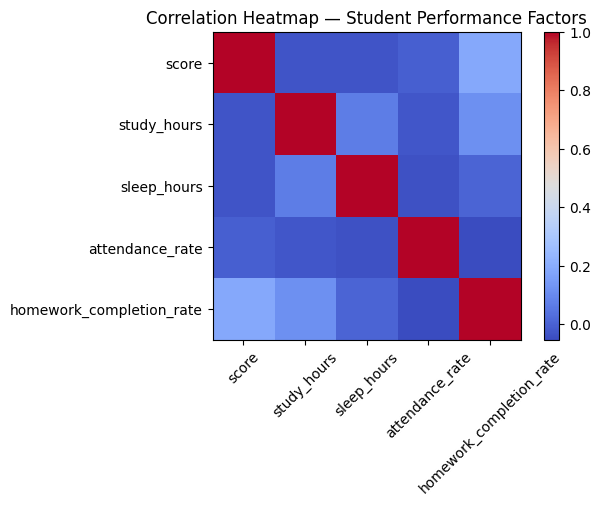


🎯 Correlation with Exam Score:
   study_hours: -0.029
   sleep_hours: -0.031
   attendance_rate: -0.004
   homework_completion_rate: 0.186


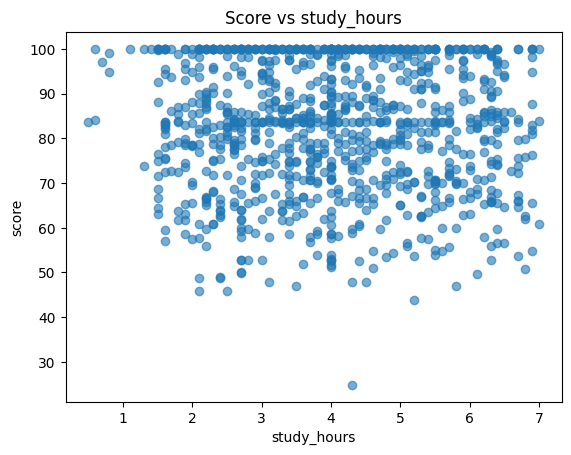

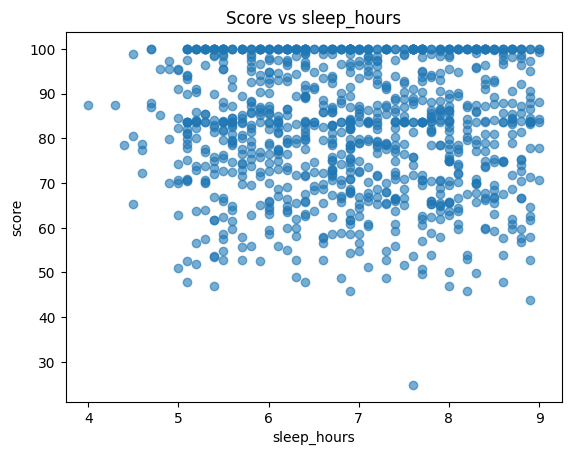

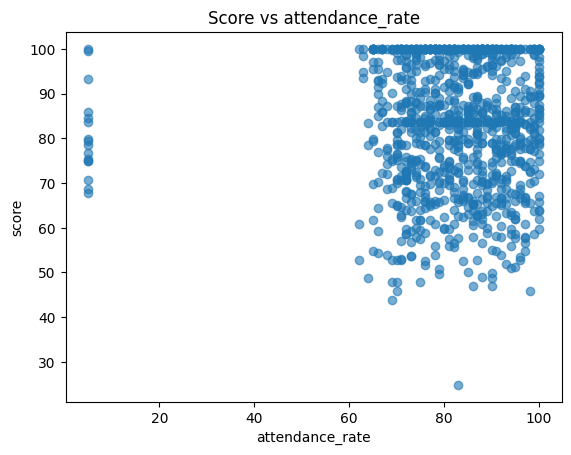

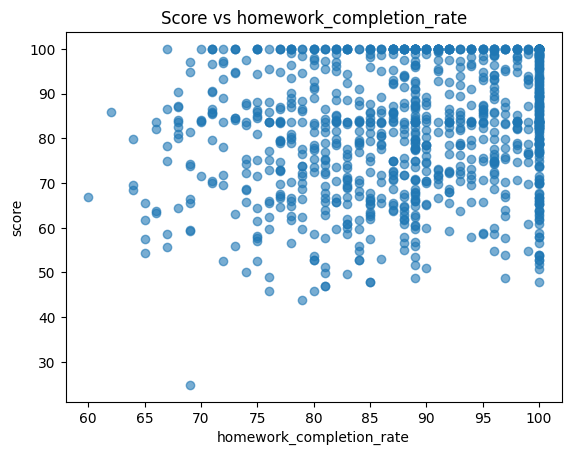

In [24]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas for easier plotting (since dataset is small)
pandas_df = df.select("score", "study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate").toPandas()

# 1️⃣ Compute Pearson correlations between numeric columns
correlation_matrix = pandas_df.corr(method="pearson")
print("📈 Pearson Correlation Matrix:")
print(correlation_matrix)

# 2️⃣ Plot correlation heatmap (for visual clarity)
plt.figure(figsize=(6,4))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Correlation Heatmap — Student Performance Factors")
plt.show()

# 3️⃣ Focused correlations with score
print("\n🎯 Correlation with Exam Score:")
for col in ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]:
    corr_val = pandas_df["score"].corr(pandas_df[col])
    print(f"   {col}: {corr_val:.3f}")

# 4️⃣ Visual exploration: scatter plots for major factors
cols_to_plot = ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate"]
for c in cols_to_plot:
    plt.figure()
    plt.scatter(pandas_df[c], pandas_df["score"], alpha=0.6)
    plt.xlabel(c)
    plt.ylabel("score")
    plt.title(f"Score vs {c}")
    plt.show()

In [25]:
from pyspark.sql import functions as F

null_summary = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_summary.show(truncate=False)

+----------+----+---+------+-----------+------------+------------+----------------+--------------+-----------+-----+-----+-----------+-----------+---------------+---------------+------------------+----------------+------------------------+--------------------------+-----------+------------+----------------+----------------+--------+--------------+--------------+----+-------+------------------+-------------+---------------+------------------------+-------------+-----------+----------+--------------+-------------+-----------+---------------+----------+-----------------+
|student_id|name|age|gender|grade_level|subject_name|teacher_name|difficulty_level|hours_per_week|description|month|score|sleep_hours|study_hours|attendance_rate|internet_access|free_time_activity|parent_education|homework_completion_rate|extracurricular_activities|family_size|previous_gpa|school_transport|health_condition|tutoring|student_status|admission_year|city|country|scholarship_status|exam_attempts|final_exam_date

In [26]:
string_cols = [c for (c, t) in df.dtypes if t == "string"]

for c in string_cols:
    df = df.withColumn(c, F.initcap(F.trim(F.col(c))))

In [28]:
df = df.withColumn("attendance_category",
                   F.when(F.col("attendance_rate") >= 90, "High")
                    .when(F.col("attendance_rate") >= 75, "Medium")
                    .otherwise("Low"))

df = df.withColumn("performance_level",
                   F.when(F.col("score") >= 85, "Excellent")
                    .when(F.col("score") >= 70, "Good")
                    .when(F.col("score") >= 50, "Average")
                    .otherwise("Weak"))

In [29]:
df.filter((F.col("attendance_rate") < 40) & (F.col("score") > 90)).show()

+----------+-----------+---+------+-----------+------------+------------+----------------+--------------+--------------------+-------------------+-----+-----------+-----------+---------------+---------------+------------------+----------------+------------------------+--------------------------+-----------+------------+----------------+----------------+--------+--------------+--------------+----------+-------+------------------+-------------+---------------+------------------------+-------------+-----------+----------+--------------+-------------+-----------+---------------+------------------+------------------+-------------------+-----------------+
|student_id|       name|age|gender|grade_level|subject_name|teacher_name|difficulty_level|hours_per_week|         description|              month|score|sleep_hours|study_hours|attendance_rate|internet_access|free_time_activity|parent_education|homework_completion_rate|extracurricular_activities|family_size|previous_gpa|school_transport|heal

In [30]:
from pyspark.sql import functions as F

# ✅ 1️⃣ Remove true duplicates (same student, same subject, same month)
unique_keys = ["student_id", "subject_name", "month"]
df = df.dropDuplicates(subset=unique_keys)

# ✅ 2️⃣ Fix negative numeric values (convert to absolute)
numeric_cols = [col for (col, dtype) in df.dtypes if dtype in ('int', 'double')]
for c in numeric_cols:
    df = df.withColumn(c, F.abs(F.col(c)))

# ✅ 3️⃣ Normalize Yes/No values to 1/0
string_cols = [c for (c, dtype) in df.dtypes if dtype == 'string']
for c in string_cols:
    df = df.withColumn(
        c,
        F.when(F.lower(F.trim(F.col(c))) == 'yes', 1)
         .when(F.lower(F.trim(F.col(c))) == 'no', 0)
         .otherwise(F.col(c))
    )

# ✅ 4️⃣ Cap attendance and rates between 0 and 100
rate_cols = [c for c in df.columns if "attendance" in c.lower() or "rate" in c.lower()]
for c in rate_cols:
    df = df.withColumn(
        c,
        F.when(F.col(c) > 100, 100)
         .when(F.col(c) < 0, 0)
         .otherwise(F.col(c))
    )

# ✅ 5️⃣ Standardize all text columns (lowercase + remove extra spaces)
string_cols = [c for (c, dtype) in df.dtypes if dtype == 'string']
for c in string_cols:
    df = df.withColumn(c, F.trim(F.lower(F.col(c))))

# ✅ 6️⃣ Cast rate columns to double for precision
for c in rate_cols:
    df = df.withColumn(c, F.col(c).cast("double"))

# ✅ 7️⃣ Handle missing values (nulls)
# For numeric columns → fill with mean
# For string columns → fill with 'unknown'
mean_dict = {}
for c in numeric_cols:
    mean_val = df.select(F.mean(F.col(c))).first()[0]
    if mean_val is not None:
        mean_dict[c] = float(mean_val)
df = df.fillna(mean_dict)

str_fill_dict = {c: 'unknown' for c in string_cols}
df = df.fillna(str_fill_dict)

# ✅ 8️⃣ Extract time features from month and final_exam_date
if "month" in df.columns:
    df = df.withColumn("exam_month_num", F.month("month"))
if "final_exam_date" in df.columns:
    df = df.withColumn("exam_final_month", F.month("final_exam_date"))
    df = df.withColumn("days_between_exam_and_month", F.datediff("final_exam_date", "month"))

# ✅ 9️⃣ Create derived ratios (if not already present)
if "sleep_hours" in df.columns and "study_hours" in df.columns:
    df = df.withColumn("sleep_study_ratio", F.round(F.col("sleep_hours") / F.when(F.col("study_hours") == 0, 1).otherwise(F.col("study_hours")), 3))
    df = df.withColumn("efficiency", F.round((F.col("study_hours") * F.col("attendance_rate") / 100), 3))

# ✅ 🔟 Remove potential outliers using reasonable boundaries (optional thresholds)
# Example thresholds for sanity check
df = df.filter((F.col("sleep_hours") <= 10) & (F.col("sleep_hours") >= 3))
df = df.filter((F.col("study_hours") <= 8) & (F.col("study_hours") >= 0.5))
df = df.filter((F.col("score") <= 100) & (F.col("score") >= 0))

# ✅ 11️⃣ Print summary
print("✅ Final cleaning complete!")
print("Final row count:", df.count())
print("Final columns:", len(df.columns))

# ✅ 12️⃣ Optional: Describe key numeric columns
df.describe(["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate", "score"]).show()

# ✅ 13️⃣ Optional: Save the clean version for reuse
df.write.mode("overwrite").option("header", True).csv("/content/student_performance_clean_final.csv")

print("📁 Clean dataset saved as student_performance_clean_final.csv")

✅ Final cleaning complete!
Final row count: 1000
Final columns: 47
+-------+------------------+------------------+------------------+------------------------+------------------+
|summary|       study_hours|       sleep_hours|   attendance_rate|homework_completion_rate|             score|
+-------+------------------+------------------+------------------+------------------------+------------------+
|  count|              1000|              1000|              1000|                    1000|              1000|
|   mean| 4.047699999999999|            6.9222|            82.037|                  88.503| 82.41959999999979|
| stddev|1.4671084203688265|1.1398624682155498|13.781275505357062|       9.441458157092692|14.188950530506371|
|    min|               0.5|               4.0|               5.0|                    60.0|              24.9|
|    max|               7.0|               9.0|             100.0|                   100.0|             100.0|
+-------+------------------+-----------------

In [31]:
# STEP 1: Average Exam Score by Month

from pyspark.sql import functions as F
import pandas as pd
import plotly.express as px

# 1️⃣ Ensure the 'month' column is in timestamp format
df = df.withColumn("month", F.to_timestamp(F.col("month")))

# 2️⃣ Group by year-month and calculate average score
avg_by_month = (
    df
    .withColumn("year_month", F.date_format(F.col("month"), "yyyy-MM"))
    .groupBy("year_month")
    .agg(
        F.count("*").alias("records_count"),
        F.round(F.avg("score"), 2).alias("avg_score")
    )
    .orderBy("year_month")
)

# 3️⃣ Convert to Pandas for plotting
pdf_month = avg_by_month.toPandas()
pdf_month["year_month_dt"] = pd.to_datetime(pdf_month["year_month"] + "-01")

# 4️⃣ Plot the line chart
fig = px.line(
    pdf_month,
    x="year_month_dt",
    y="avg_score",
    markers=True,
    title="Average Exam Score by Month",
    labels={"year_month_dt": "Month", "avg_score": "Average Score"}
)

fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    hovermode="x unified"
)

fig.show()

In [32]:
# STEP 2: Average Exam Score by Subject

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by subject_name and calculate average score
avg_by_subject = (
    df.groupBy("subject_name")
      .agg(
          F.count("*").alias("records_count"),
          F.round(F.avg("score"), 2).alias("avg_score")
      )
      .orderBy(F.desc("avg_score"))
)

# 2️⃣ Convert to pandas for visualization
pdf_subject = avg_by_subject.toPandas()

# 3️⃣ Optional: filter out subjects with very few records (less reliable averages)
pdf_subject = pdf_subject[pdf_subject["records_count"] >= 3]

# 4️⃣ Sort by average score descending
pdf_subject = pdf_subject.sort_values("avg_score", ascending=False)

# 5️⃣ Plot bar chart
fig = px.bar(
    pdf_subject,
    x="subject_name",
    y="avg_score",
    color="avg_score",
    hover_data=["records_count"],
    title="Average Exam Score by Subject",
    labels={"subject_name": "Subject", "avg_score": "Average Score"}
)

fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis_tickangle=45
)

fig.show()

In [33]:
# STEP 3: Relation between Study Hours and Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Select the needed columns
study_score_df = df.select("study_hours", "score", "difficulty_level")

# 2️⃣ Convert to pandas for visualization (sample if data is large)
pdf_study_score = study_score_df.toPandas()

# Optional: if you have thousands of rows, sample 2000 for faster plotting
if len(pdf_study_score) > 2000:
    pdf_study_score = pdf_study_score.sample(2000, random_state=42)

# 3️⃣ Scatter plot
fig = px.scatter(
    pdf_study_score,
    x="study_hours",
    y="score",
    color="difficulty_level",  # color by difficulty (optional)
    title="Study Hours vs Exam Score",
    labels={"study_hours": "Study Hours", "score": "Exam Score"},
    opacity=0.7,
    trendline="ols"  # add regression line (trendline)
)

# 4️⃣ Layout and style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    hovermode="closest"
)

fig.show()

In [34]:
# STEP 4: Relation between Sleep Hours and Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Select needed columns
sleep_score_df = df.select("sleep_hours", "score", "health_condition")

# 2️⃣ Convert to Pandas for visualization
pdf_sleep_score = sleep_score_df.toPandas()

# Optional sampling for large data
if len(pdf_sleep_score) > 2000:
    pdf_sleep_score = pdf_sleep_score.sample(2000, random_state=42)

# 3️⃣ Scatter plot
fig = px.scatter(
    pdf_sleep_score,
    x="sleep_hours",
    y="score",
    color="health_condition",  # color by health condition
    title="Sleep Hours vs Exam Score",
    labels={"sleep_hours": "Sleep Hours (Night Before Exam)", "score": "Exam Score"},
    opacity=0.7,
    trendline="ols"  # regression line
)

# 4️⃣ Layout and style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    hovermode="closest"
)

fig.show()

In [35]:
# STEP 5: Attendance Rate vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by attendance_rate (rounded to nearest 10%)
df_attendance = (
    df.withColumn("attendance_group", (F.col("attendance_rate") / 10).cast("int") * 10)
      .groupBy("attendance_group")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("attendance_group")
)

# 2️⃣ Convert to pandas
pdf_attendance = df_attendance.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_attendance,
    x="attendance_group",
    y="avg_score",
    title="Attendance Rate vs Average Exam Score",
    labels={"attendance_group": "Attendance Rate (%)", "avg_score": "Average Exam Score"},
    text_auto=".2f"
)

# 4️⃣ Style
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis=dict(dtick=10),
    yaxis=dict(range=[0, 100])
)

fig.show()

In [36]:
# STEP 6: Homework Completion Rate vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by homework_completion_rate (rounded to nearest 10%)
df_homework = (
    df.withColumn("homework_group", (F.col("homework_completion_rate") / 10).cast("int") * 10)
      .groupBy("homework_group")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("homework_group")
)

# 2️⃣ Convert to Pandas
pdf_homework = df_homework.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_homework,
    x="homework_group",
    y="avg_score",
    title="Homework Completion Rate vs Average Exam Score",
    labels={"homework_group": "Homework Completion Rate (%)", "avg_score": "Average Exam Score"},
    text_auto=".2f"
)

# 4️⃣ Style and layout
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    xaxis=dict(dtick=10),
    yaxis=dict(range=[0, 100])
)

fig.show()

In [37]:
# STEP 7: Health Condition vs Average Exam Score

from pyspark.sql import functions as F
import plotly.express as px

# 1️⃣ Group by health_condition
df_health = (
    df.groupBy("health_condition")
      .agg(F.avg("score").alias("avg_score"))
      .orderBy("health_condition")
)

# 2️⃣ Convert to Pandas for visualization
pdf_health = df_health.toPandas()

# 3️⃣ Bar chart
fig = px.bar(
    pdf_health,
    x="health_condition",
    y="avg_score",
    title="Health Condition vs Average Exam Score",
    labels={"health_condition": "Health Condition", "avg_score": "Average Exam Score"},
    text_auto=".2f",
    color="health_condition"
)

# 4️⃣ Style and layout
fig.update_layout(
    title_x=0.5,
    template="plotly_white",
    showlegend=False,
    yaxis=dict(range=[0, 100])
)

fig.show()

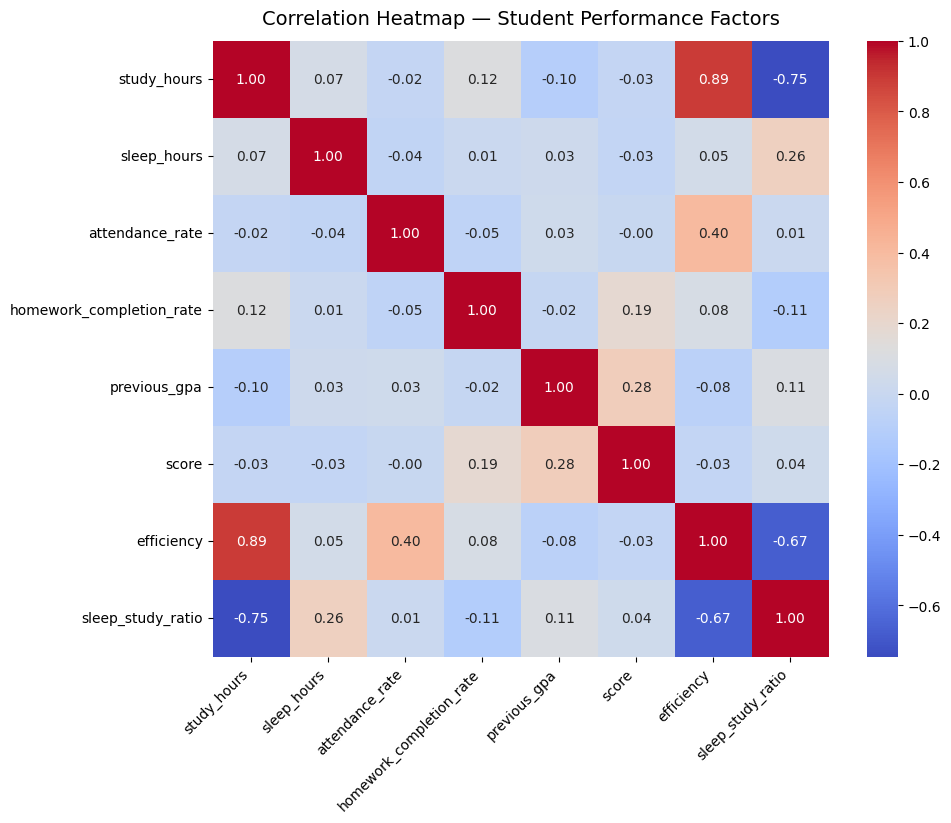

In [38]:
# STEP 8: Correlation Heatmap between numeric variables

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# 1️⃣ Select numeric columns (you can adjust this list)
numeric_cols = [
    "study_hours", "sleep_hours", "attendance_rate",
    "homework_completion_rate", "previous_gpa",
    "score", "efficiency", "sleep_study_ratio"
]

# 2️⃣ Convert to Pandas
pdf_corr = df.select(numeric_cols).toPandas()

# 3️⃣ Compute correlation matrix
corr_matrix = pdf_corr.corr()

# 4️⃣ Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,       # show correlation values
    fmt=".2f",
    cmap="coolwarm",  # color gradient
    square=True,
    cbar=True
)

plt.title("Correlation Heatmap — Student Performance Factors", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

In [39]:
# Install Plotly and ipywidgets (if not already installed)
!pip install -q plotly ipywidgets
from IPython.display import display
import plotly.express as px
import ipywidgets as widgets

# Prepare base dataframe
pdf = df.toPandas()

# Convert month column to readable string
pdf["month"] = pdf["month"].astype(str).str[:7]  # e.g., 2023-09

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


In [40]:
# Dropdown filters
subject_dropdown = widgets.Dropdown(
    options=sorted(pdf["subject_name"].dropna().unique()),
    value=sorted(pdf["subject_name"].dropna().unique())[0],
    description='Subject:',
    style={'description_width': 'initial'}
)

health_dropdown = widgets.Dropdown(
    options=['All'] + sorted(pdf["health_condition"].dropna().unique()),
    value='All',
    description='Health:',
    style={'description_width': 'initial'}
)

month_dropdown = widgets.Dropdown(
    options=['All'] + sorted(pdf["month"].dropna().unique()),
    value='All',
    description='Month:',
    style={'description_width': 'initial'}
)

In [41]:
def update_dashboard(subject, health, month):
    data = pdf.copy()

    # Apply filters
    if subject:
        data = data[data["subject_name"] == subject]
    if health != 'All':
        data = data[data["health_condition"] == health]
    if month != 'All':
        data = data[data["month"] == month]

    # === 1️⃣ Average Score per Subject ===
    fig1 = px.bar(
        data.groupby("subject_name")["score"].mean().reset_index(),
        x="subject_name", y="score",
        title="Average Score per Subject",
        labels={"score": "Average Score"}
    )

    # === 2️⃣ Study Hours vs Score ===
    fig2 = px.scatter(
        data, x="study_hours", y="score",
        color="difficulty_level", opacity=0.7,
        title="Study Hours vs Exam Score", trendline="ols"
    )

    # === 3️⃣ Sleep Hours vs Score ===
    fig3 = px.scatter(
        data, x="sleep_hours", y="score",
        color="health_condition", opacity=0.7,
        title="Sleep Hours vs Exam Score", trendline="ols"
    )

    # === 4️⃣ Attendance Rate vs Score ===
    att = data.groupby("attendance_rate")["score"].mean().reset_index()
    fig4 = px.line(att, x="attendance_rate", y="score",
                   title="Attendance Rate vs Average Score", markers=True)

    # === 5️⃣ Homework Completion Rate vs Score ===
    hw = data.groupby("homework_completion_rate")["score"].mean().reset_index()
    fig5 = px.line(hw, x="homework_completion_rate", y="score",
                   title="Homework Completion Rate vs Average Score", markers=True)

    # === 6️⃣ Health Condition vs Score ===
    fig6 = px.bar(
        data.groupby("health_condition")["score"].mean().reset_index(),
        x="health_condition", y="score",
        title="Health Condition vs Average Score",
        text_auto=".2f"
    )

    # === 7️⃣ Correlation Heatmap ===
    import seaborn as sns
    import matplotlib.pyplot as plt
    corr_cols = ["study_hours", "sleep_hours", "attendance_rate",
                 "homework_completion_rate", "previous_gpa", "score"]
    corr = data[corr_cols].corr()
    plt.figure(figsize=(6, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Show all plotly charts
    fig1.show()
    fig2.show()
    fig3.show()
    fig4.show()
    fig5.show()
    fig6.show()

In [42]:
# Display interactive filters
widgets.interact(
    update_dashboard,
    subject=subject_dropdown,
    health=health_dropdown,
    month=month_dropdown
)

interactive(children=(Dropdown(description='Subject:', options=('arabic', 'english', 'history', 'math', 'scien…

<function __main__.update_dashboard(subject, health, month)>

In [46]:
from google.colab import output
output.enable_custom_widget_manager()

In [47]:
# ============================================================
# 🎯 Full Interactive Dashboard with KPIs + Heatmap + Pie
# ============================================================

!pip install -q plotly ipywidgets seaborn

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML
import numpy as np

# Convert PySpark to Pandas
pdf = df.toPandas().copy()
pdf["month"] = pdf["month"].astype(str).str[:7]

# ============================================================
# 1️⃣ Create dropdown filters
# ============================================================

subject_dropdown = widgets.Dropdown(
    options=sorted(pdf["subject_name"].dropna().unique()),
    value=sorted(pdf["subject_name"].dropna().unique())[0],
    description='🎓 Subject:',
    style={'description_width': 'initial'}
)

health_dropdown = widgets.Dropdown(
    options=['All'] + sorted(pdf["health_condition"].dropna().unique()),
    value='All',
    description='💊 Health:',
    style={'description_width': 'initial'}
)

month_dropdown = widgets.Dropdown(
    options=['All'] + sorted(pdf["month"].dropna().unique()),
    value='All',
    description='🗓 Month:',
    style={'description_width': 'initial'}
)

# ============================================================
# 2️⃣ Define dashboard update function
# ============================================================

def update_dashboard(subject, health, month):
    data = pdf.copy()

    # Apply filters
    if subject:
        data = data[data["subject_name"] == subject]
    if health != 'All':
        data = data[data["health_condition"] == health]
    if month != 'All':
        data = data[data["month"] == month]

    # ========================================================
    # KPIs Section (Top Summary Cards)
    # ========================================================
    avg_score = round(data["score"].mean(), 2)
    avg_study = round(data["study_hours"].mean(), 2)
    avg_sleep = round(data["sleep_hours"].mean(), 2)
    avg_attendance = round(data["attendance_rate"].mean(), 2)
    avg_homework = round(data["homework_completion_rate"].mean(), 2)

    kpi_html = f"""
    <div style='display:flex; justify-content:space-around; background:#f7f9fb; padding:15px; border-radius:10px;'>
        <div style='text-align:center;'>
            <h3>📊 Average Score</h3>
            <h2 style='color:#2E86C1;'>{avg_score}</h2>
        </div>
        <div style='text-align:center;'>
            <h3>📚 Study Hours</h3>
            <h2 style='color:#28B463;'>{avg_study}</h2>
        </div>
        <div style='text-align:center;'>
            <h3>😴 Sleep Hours</h3>
            <h2 style='color:#AF7AC5;'>{avg_sleep}</h2>
        </div>
        <div style='text-align:center;'>
            <h3>🕒 Attendance (%)</h3>
            <h2 style='color:#E67E22;'>{avg_attendance}</h2>
        </div>
        <div style='text-align:center;'>
            <h3>💻 Homework (%)</h3>
            <h2 style='color:#CB4335;'>{avg_homework}</h2>
        </div>
    </div>
    """
    display(HTML(kpi_html))

    # ========================================================
    # Charts Section (4 rows × 2 cols)
    # ========================================================
    fig = make_subplots(
        rows=4, cols=2,
        subplot_titles=(
            "📘 Study Hours vs Score",
            "😴 Sleep Hours vs Score",
            "🧾 Attendance Rate vs Score",
            "📚 Homework Completion vs Score",
            "❤ Health Condition vs Score",
            "⭐ Feedback Rating vs Score",
            "📈 Correlation Heatmap",
            "🍰 Health & Tutoring Distribution"
        ),
        vertical_spacing=0.12,
        horizontal_spacing=0.1,
        specs=[
            [{}, {}],
            [{}, {}],
            [{}, {}],
            [{"type": "heatmap"}, {"type": "domain"}]
        ]
    )

    # 1️⃣ Study Hours vs Score
    scatter1 = px.scatter(data, x="study_hours", y="score", color="difficulty_level", opacity=0.7)
    for trace in scatter1.data:
        fig.add_trace(trace, row=1, col=1)

    # 2️⃣ Sleep Hours vs Score
    scatter2 = px.scatter(data, x="sleep_hours", y="score", color="health_condition", opacity=0.7)
    for trace in scatter2.data:
        fig.add_trace(trace, row=1, col=2)

    # 3️⃣ Attendance Rate vs Score
    att = data.groupby("attendance_rate")["score"].mean().reset_index()
    fig.add_trace(go.Scatter(x=att["attendance_rate"], y=att["score"], mode="lines+markers"), row=2, col=1)

    # 4️⃣ Homework Completion vs Score
    hw = data.groupby("homework_completion_rate")["score"].mean().reset_index()
    fig.add_trace(go.Scatter(x=hw["homework_completion_rate"], y=hw["score"], mode="lines+markers"), row=2, col=2)

    # 5️⃣ Health Condition vs Score
    hc = data.groupby("health_condition")["score"].mean().reset_index()
    fig.add_trace(go.Bar(x=hc["health_condition"], y=hc["score"], marker_color="lightcoral"), row=3, col=1)

    # 6️⃣ Feedback Rating vs Score
    fb = data.groupby("feedback_rating")["score"].mean().reset_index()
    fig.add_trace(go.Scatter(x=fb["feedback_rating"], y=fb["score"], mode="markers+lines", marker_color="teal"), row=3, col=2)

    # 7️⃣ Correlation Heatmap
    corr_cols = ["study_hours", "sleep_hours", "attendance_rate", "homework_completion_rate", "previous_gpa", "score"]
    corr = data[corr_cols].corr()
    heatmap_trace = go.Heatmap(
        z=corr.values, x=corr.columns, y=corr.columns,
        colorscale="RdBu", zmin=-1, zmax=1,
        text=np.round(corr.values, 2), texttemplate="%{text}"
    )
    fig.add_trace(heatmap_trace, row=4, col=1)

    # 8️⃣ Pie Chart — Health & Tutoring
    health_dist = data["health_condition"].value_counts().reset_index()
    health_dist.columns = ["Health Condition", "Count"]
    tutoring_dist = data["tutoring"].value_counts().reset_index()
    tutoring_dist.columns = ["Tutoring", "Count"]

    pie_labels = list(health_dist["Health Condition"]) + ["Tutoring: Yes", "Tutoring: No"]
    pie_values = list(health_dist["Count"]) + list(tutoring_dist["Count"])

    fig.add_trace(go.Pie(labels=pie_labels, values=pie_values, hole=0.4), row=4, col=2)

    # Layout
    fig.update_layout(
        height=1650,
        width=1150,
        showlegend=False,
        title={
            "text": f"🎓 Student Performance Dashboard — {subject}",
            "x": 0.5, "xanchor": "center"
        },
        template="plotly_white",
        font=dict(size=12),
        margin=dict(t=100)
    )

    fig.show()

# ============================================================
# 3️⃣ Display Dashboard
# ============================================================

ui = widgets.VBox([widgets.HBox([subject_dropdown, health_dropdown, month_dropdown])])
out = widgets.interactive_output(update_dashboard, {"subject": subject_dropdown, "health": health_dropdown, "month": month_dropdown})

display(ui, out)

Output()